### 1. Parametry sesji

In [12]:
### 1) Parametry sesji

"""
Inicjalizacja parametrów bieżącego uruchomienia notebooka.

Ustawiane pola:
- RUN_ID      – unikalny identyfikator sesji (do logów, nazw plików)
- SEED        – ziarno losowości dla powtarzalności
- PRECISION   – 'fp16' lub 'fp32' (dla modeli CLIP / YOLO)
- DTYPE       – odpowiadający typ torch (torch.float16 / torch.float32)
- TARGET_ENV  – 'local' lub 'gcp' (wpływa na ścieżki I/O)
- DEVICE      – 'mps' | 'cuda' | 'cpu'
- VERS        – wersje kluczowych bibliotek (ślad auditowy)
"""

from datetime import datetime, timezone
import platform
import random
import numpy as np
import torch

# ------------------------------
# Znacznik czasu i RUN_ID
# ------------------------------
TS_UTC = datetime.now(timezone.utc)
RUN_ID = TS_UTC.strftime("%Y%m%d_%H%M%S_A1")  # np. 20251127_113104_A1

# ------------------------------
# Seed i losowość
# ------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------
# Wybór urządzenia obliczeniowego
# ------------------------------
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

# ------------------------------
# Precyzja obliczeń
# ------------------------------
PRECISION = "fp16"
DTYPE = torch.float16 if PRECISION == "fp16" else torch.float32

# ------------------------------
# Środowisko docelowe
# (może być nadpisane z .env w kolejnej komórce)
# ------------------------------
TARGET_ENV = "local"

# ------------------------------
# Wersje środowiskowe (do logów)
# ------------------------------
VERS = {
    "python": platform.python_version(),
    "torch": torch.__version__,
}

{
    "run_id": RUN_ID,
    "ts_utc": TS_UTC.isoformat(timespec="seconds"),
    "device": DEVICE,
    "precision": PRECISION,
    "dtype": str(DTYPE),
    "target_env": TARGET_ENV,
}

{'run_id': '20251127_110102_A1',
 'ts_utc': '2025-11-27T11:01:02+00:00',
 'device': 'mps',
 'precision': 'fp16',
 'dtype': 'torch.float16',
 'target_env': 'local'}

### 2. Importy i wersje

In [31]:
"""
Importy, wersje bibliotek i minimalna telemetria środowiska.
"""

import os, sys, json, time, random, platform, math
from pathlib import Path
import numpy as np

# opcjonalni zależni – łagodna degradacja
try:
    import torch
except Exception:
    torch = None

try:
    import open_clip
except Exception:
    open_clip = None

try:
    from ultralytics import YOLO
except Exception:
    YOLO = None

try:
    from paddleocr import PaddleOCR
except Exception:
    PaddleOCR = None

try:
    from PIL import Image
except Exception:
    Image = None

try:
    import yaml
except Exception:
    yaml = None

try:
    import pandas as pd
except Exception:
    pd = None

try:
    from dotenv import load_dotenv
except Exception:
    load_dotenv = None

# wersje bibliotek
VERS = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": getattr(pd, "__version__", None) if pd else None,
    "torch": getattr(torch, "__version__", None),
    "open_clip": getattr(open_clip, "__version__", None) if open_clip else None,
    "ultralytics": getattr(YOLO, "__module__", None) if YOLO else None,
    "paddleocr": getattr(PaddleOCR, "__module__", None) if PaddleOCR else None,
    "pillow": getattr(Image, "__version__", None) if Image else None,
    "pyyaml": getattr(yaml, "__version__", None) if yaml else None,
}

# minimalna kontrola kluczowych zależności dla pipeline'u
DEPS_OK = {
    "numpy": np is not None,
    "pandas": pd is not None,
    "Pillow": Image is not None,
    "torch": torch is not None,
}

{"versions": VERS, "deps_ok": DEPS_OK}

{'versions': {'python': '3.13.7',
  'platform': 'macOS-26.1-arm64-arm-64bit-Mach-O',
  'numpy': '1.26.4',
  'pandas': '2.2.3',
  'torch': '2.9.0',
  'open_clip': '3.2.0',
  'ultralytics': 'ultralytics.models.yolo.model',
  'paddleocr': 'paddleocr._pipelines.ocr',
  'pillow': '12.0.0',
  'pyyaml': '6.0.2'},
 'deps_ok': {'numpy': True, 'pandas': True, 'Pillow': True, 'torch': True}}

### 3. Detekcja urządzenia i dtype

In [32]:
"""
Wybór urządzenia obliczeń i typu danych dla CLIP oraz diagnostyka dostępnego hardware.

Zasady:
- Mac: preferuj mps → cpu
- GCP: preferuj cuda → cpu
- PRECISION steruje dtype (fp16 domyślnie)
"""

def get_device():
    if torch is None:
        return "cpu"
    # Apple Silicon
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    # GPU NVIDIA (GCP, Colab)
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"

def get_dtype(precision: str):
    if torch is None:
        return None
    p = precision.lower()
    if p == "fp16":
        return torch.float16
    if p == "bf16":
        return torch.bfloat16
    return torch.float32

DEVICE = get_device()
DTYPE = get_dtype(PRECISION)

# --- diagnostyka ---
diag = {}

if DEVICE == "cuda":
    diag["cuda_available"] = torch.cuda.is_available()
    diag["cuda_device"] = torch.cuda.get_device_name(0)
elif DEVICE == "mps":
    diag["mps_available"] = torch.backends.mps.is_available()
else:
    diag["note"] = "CPU fallback – brak akceleracji"

{
    "device": DEVICE,
    "dtype": str(DTYPE),
    "diagnostics": diag
}

{'device': 'mps',
 'dtype': 'torch.float16',
 'diagnostics': {'mps_available': True}}

### 4. Seed i deterministyka

In [16]:
"""
Ustawienie seed i trybu deterministycznego tam, gdzie to rozsądne.
"""

random.seed(SEED)
np.random.seed(SEED)
if torch is not None:
    torch.manual_seed(SEED)
    if DEVICE == "cuda":
        torch.cuda.manual_seed_all(SEED)
    try:
        torch.use_deterministic_algorithms(False)  # True może spowalniać; wyłączone na bootstrapie
    except Exception:
        pass
{"seed": SEED}

{'seed': 42}

### 5. Ścieżki projektu i katalogi

In [30]:
"""
Definicja ścieżek bazowych i tworzenie katalogów zgodnie z konwencją projektu.
"""

ROOT = Path.cwd().resolve()

DIRS = {
    # konfiguracje i metadata
    "configs": ROOT / "configs",

    # dane wejściowe
    "inputs": ROOT / "inputs",
    "data_raw": ROOT / "data/raw",
    "data_staging": ROOT / "data/staging",
    "data_processed": ROOT / "data/processed",

    # modele
    "models_clip": ROOT / "models/clip",
    "models_yolo": ROOT / "models/yolo",

    # artefakty modułów
    "out_previews": ROOT / "outputs/previews",
    "out_clip_epoch": ROOT / "outputs/clip_epoch",
    "out_yolo": ROOT / "outputs/yolo",
    "out_ocr": ROOT / "outputs/ocr",

    # katalog CSV – wspólny dla 02–07
    "out_csv": ROOT / "outputs/csv",

    # eksporty Dublin Core
    "exports": ROOT / "exports/dlibra_csv",

    # logi
    "logs": ROOT / "logs",
    "logs_audit": ROOT / "logs/audit",
}

# tworzenie katalogów
for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

{k: str(v) for k, v in DIRS.items()}

### Walidacja struktury katalogów

missing = [k for k,v in DIRS.items() if not v.exists()]
if missing:
    raise RuntimeError(f"Brakujące katalogi: {missing}")
else:
    print("Struktura katalogów OK.")


Struktura katalogów OK.


### 6. Loader .env

In [18]:
"""
Ładowanie .env (jeśli istnieje) oraz inicjalizacja minimalnych plików YAML.
Tworzy pliki tylko wtedy, gdy nie istnieją — nie nadpisuje edytowanych configów.
"""

from pathlib import Path
import os
from dotenv import load_dotenv

# ---------------------------------------
# 0. Przygotowanie DIRS, jeśli kernel został zresetowany
# ---------------------------------------
if "DIRS" not in globals():
    ROOT = Path.cwd().resolve()
    DIRS = {
        "configs": ROOT / "configs",
        "logs": ROOT / "logs",
        "logs_audit": ROOT / "logs" / "audit",
        "out_csv": ROOT / "outputs" / "csv",
    }
    for p in DIRS.values():
        p.mkdir(parents=True, exist_ok=True)

# ---------------------------------------
# 1. Używamy TARGET_ENV z komórki 1
# ---------------------------------------
# (już istnieje, więc nic nie zmieniamy)

# ---------------------------------------
# 2. Ładowanie .env, jeśli istnieje
# ---------------------------------------
env_path = Path(".env")
if env_path.exists():
    load_dotenv(env_path)
else:
    print("Brak pliku .env — używam wartości domyślnych.")

# ---------------------------------------
# 3. Nadpisanie TARGET_ENV wartością z .env
# ---------------------------------------
TARGET_ENV = os.getenv("TARGET_ENV", TARGET_ENV)
if TARGET_ENV not in {"local", "gcp"}:
    raise ValueError(f"Nieprawidłowa wartość TARGET_ENV: {TARGET_ENV}")

# ---------------------------------------
# 4. Pomocnicza funkcja create-if-missing
# ---------------------------------------
def write_if_missing(path: Path, content: str):
    if not path.exists():
        path.write_text(content, encoding="utf-8")
        print(f"[OK] Utworzono: {path}")
    else:
        print(f"[SKIP] Istnieje: {path}")

# ---------------------------------------
# 5. Minimalny config ui.yaml
# ---------------------------------------
ui_yaml = f"""\
defaults:
  input_dir: "data/staging"
  n_preview: 24
  enable_yolo: false
  enable_ocr: true
  epoch_mode: "zero-shot"
  target_env: "{TARGET_ENV}"
"""

write_if_missing(DIRS["configs"] / "ui.yaml", ui_yaml)

# ---------------------------------------
# 6. Podsumowanie
# ---------------------------------------
{"TARGET_ENV": TARGET_ENV}

[SKIP] Istnieje: /Users/olga/MetaLogic/configs/ui.yaml


{'TARGET_ENV': 'local'}

### 7. Runlog helper

In [19]:
### 7) Runlog helper

from datetime import datetime, timezone
import json

RUNLOG_PATH = DIRS["logs"] / "runlog.jsonl"
RUNLOG_PATH.parent.mkdir(parents=True, exist_ok=True)

def log_step(step: str, params: dict, status: str, duration_s: float):
    ts = datetime.now(timezone.utc).isoformat(timespec="seconds").replace("+00:00", "Z")

    rec = {
        "ts": ts,
        "run_id": RUN_ID,
        "step": step,
        "params": params,
        "status": status,
        "duration_s": round(float(duration_s), 3),
        "env": {
            "device": DEVICE,
            "precision": PRECISION,
            "dtype": str(DTYPE),
            "target_env": TARGET_ENV,
            "versions": VERS,
        },
    }

    with RUNLOG_PATH.open("a", encoding="utf-8") as f:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

log_step("prepare_env", {"seed": SEED}, "ok", 0.0)

RUNLOG_PATH.as_posix()

'/Users/olga/MetaLogic/logs/runlog.jsonl'

### 8. Smoke-test I/O obrazów

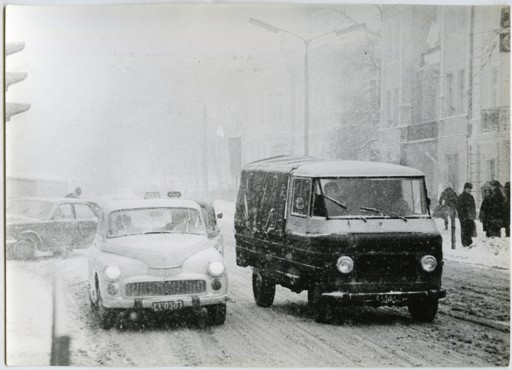

In [26]:
"""
Test I/O: znajdź pierwszy obraz w data/raw lub data/staging, zrób miniaturę 512 px
i zapisz do outputs/previews/<RUN_ID>_iocheck.jpg.

Miniatura pełni wyłącznie funkcję testową:
- potwierdza, że struktura katalogów jest poprawna,
- Pillow działa prawidłowo,
- obraz da się wczytać i zapisać,
- ścieżki I/O są poprawne (permissions, zapisywalność).
"""

import time
from IPython.display import Image as IPyImage, display, HTML

t0 = time.time()
preview_file = DIRS["out_previews"] / f"{RUN_ID}_iocheck.jpg"
preview_file.parent.mkdir(parents=True, exist_ok=True)

found = None
for base_key in ("data_staging", "data_raw"):
    base = DIRS[base_key]
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff", "*.bmp"):
        files = list(base.rglob(ext))
        if files:
            found = files[0]
            break
    if found:
        break

if Image is None:
    status = "no_pillow"
elif found is None:
    status = "no_images"
else:
    try:
        im = Image.open(found)
        im = im.convert("RGB")
        im.thumbnail((512, 512))   # miniatura testowa (nie używana w pipeline)
        im.save(preview_file, format="JPEG", quality=90)
        status = "ok"
    except Exception as e:
        status = f"error:{e}"

log_step(
    "smoketest_io",
    {"input": str(found) if found else None, "preview": str(preview_file)},
    status,
    time.time() - t0,
)

{
    "status": status,
    "input": str(found) if found else None,
    "preview": preview_file.as_posix(),
}

# Opcjonalna wizualizacja miniatury w notebooku (jedna miniatura + podpis)
if status == "ok":
    display(IPyImage(filename=preview_file))
    display(HTML(
        "<p style='font-size:13px;color:#666;'>"
        "Miniatura testowa: sprawdzenie poprawności I/O (wczytanie → skalowanie → zapis)."
        "</p>"
    ))

### 9. Smoke-test CLIP + FP16 zgodność

In [27]:
"""
Test CLIP: załaduj ViT-B/32 (open_clip), policz embedding obrazu i tekstu,
wypisz dtype i cos-sim. Wymuś spójność PRECISION.
"""

t0 = time.time()
status = "skip"
details = {}

if (open_clip is not None) and (torch is not None) and (Image is not None):
    try:
        model_name = "ViT-B-32"
        pretrained = "openai"
        model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=DEVICE)
        tokenizer = open_clip.get_tokenizer(model_name)

        # dtype i urządzenie
        if PRECISION.lower() == "fp16" and DTYPE == torch.float16 and DEVICE in ("cuda","mps"):
            model = model.to(dtype=torch.float16)
        elif PRECISION.lower() == "bf16" and DTYPE == torch.bfloat16 and DEVICE == "cuda":
            model = model.to(dtype=torch.bfloat16)
        else:
            model = model.to(dtype=torch.float32)

        # wybór obrazu do testu: weź ten sam co w smoketest_io albo syntetyczny
        test_img = None
        if 'found' in globals() and found:
            test_img = Image.open(found).convert("RGB")
        else:
            # syntetyczny 256x256
            from PIL import ImageDraw
            test_img = Image.new("RGB",(256,256),(128,128,128))
            d = ImageDraw.Draw(test_img)
            d.rectangle([64,64,192,192], outline=(255,255,255), width=4)

        img_tensor = preprocess(test_img).unsqueeze(0)
        txt = ["zdjęcie ulicy", "zdjęcie wnętrza"]
        tok = tokenizer(txt)

        # przerzut na device + dtype
        img_tensor = img_tensor.to(DEVICE)
        tok = tok.to(DEVICE)

        if model.visual.conv1.weight.dtype != img_tensor.dtype:
            # dopasuj dtype wejścia do modelu
            img_tensor = img_tensor.to(model.visual.conv1.weight.dtype)

        with torch.no_grad():
            img_feat = model.encode_image(img_tensor)
            txt_feat = model.encode_text(tok)
            # normalizacja
            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
            txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
            sim = (img_feat @ txt_feat.T).softmax(dim=-1).squeeze(0).tolist()

        details = {
            "model":"open_clip:ViT-B-32",
            "device": DEVICE,
            "model_dtype": str(next(model.parameters()).dtype),
            "input_dtype": str(img_tensor.dtype),
            "similarity": sim,
        }
        status = "ok"
    except Exception as e:
        status = f"error:{e}"
else:
    status = "deps_missing"

log_step("smoketest_clip", details, status, time.time()-t0)
{"status": status, **details}

/Users/olga/MetaLogic/.venv/lib/python3.13/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


{'status': 'ok',
 'model': 'open_clip:ViT-B-32',
 'device': 'mps',
 'model_dtype': 'torch.float16',
 'input_dtype': 'torch.float16',
 'similarity': [0.5, 0.5]}

### 10. Smoke-test YOLO (opcjonalny)

In [29]:
"""
Test YOLO: jeśli 'ultralytics' dostępne, uruchom detekcję na jednym obrazie.
Nie zapisuje wyników – tylko liczba detekcji (det_count) do logów.

Parametry:
- ENABLE_YOLO_SMOKETEST – czy test w ogóle uruchamiać
- model                  – yolov8n.pt (lekki model sanity-check)
- conf                   – próg ufności (0.25)
"""

ENABLE_YOLO_SMOKETEST = False  # ustaw True, gdy chcesz sprawdzić YOLO

if ENABLE_YOLO_SMOKETEST:
    t0 = time.time()
    status = "skip"
    det_count = None

    if (YOLO is not None) and ("found" in globals()) and found:
        try:
            model_name = "yolov8n.pt"
            conf_th = 0.25

            model = YOLO(model_name)
            res = model.predict(
                source=str(found),
                imgsz=640,
                conf=conf_th,
                verbose=False,
                device=0 if DEVICE == "cuda" else DEVICE,  # cuda:0 / cpu / mps
            )

            det_count = int(sum(len(r.boxes) for r in res))
            status = "ok"
        except Exception as e:
            status = f"error:{e}"
    else:
        status = "deps_missing_or_no_image"

    log_step(
        "smoketest_yolo",
        {
            "input": str(found) if "found" in globals() else None,
            "det_count": det_count,
            "model": "yolov8n.pt",
            "device": DEVICE,
            "conf": 0.25,
        },
        status,
        time.time() - t0,
    )

    {"status": status, "det_count": det_count}
else:
    print("YOLO smoketest pominięty (ENABLE_YOLO_SMOKETEST=False)")

YOLO smoketest pominięty (ENABLE_YOLO_SMOKETEST=False)


### 11. Podsumowanie sesji

In [33]:
"""
Podsumowanie 00_bootstrap: urządzenie, precyzja, pliki wyjściowe, wskazówki dalszych kroków.
"""

summary = {
    "run_id": RUN_ID,
    "device": DEVICE,
    "precision": PRECISION,
    "dtype": str(DTYPE),
    "target_env": TARGET_ENV,
    "created_dirs": [str(p) for p in DIRS.values()],
    "runlog": RUNLOG_PATH.as_posix(),
    "preview_hint": f"outputs/previews/{RUN_ID}_iocheck.jpg",
}
print(json.dumps(summary, indent=2, ensure_ascii=False))

print("\nNastępne kroki:")
print("1) 01_ingest.ipynb – przygotowanie / wybór zbioru obrazów.")
print("2) 02_clip_zero_shot.ipynb – klasyfikacja zero-shot (okresy / etykiety scen).")
print("3) 03_clip_scene_classification.ipynb – sceny / kontekst miejsca.")
print("4) 04_yolo_objects.ipynb – detekcja obiektów (YOLO).")
print("5) 05_ocr_pipeline.ipynb – OCR i teksty na obrazach.")
print("6) 06_quality_metrics.ipynb – metryki jakości / ostrości.")
print("7) 07_human_review_and_dc_export.ipynb – przegląd ręczny i eksport Dublin Core CSV.")

{
  "run_id": "20251127_110102_A1",
  "device": "mps",
  "precision": "fp16",
  "dtype": "torch.float16",
  "target_env": "local",
  "created_dirs": [
    "/Users/olga/MetaLogic/configs",
    "/Users/olga/MetaLogic/inputs",
    "/Users/olga/MetaLogic/data/raw",
    "/Users/olga/MetaLogic/data/staging",
    "/Users/olga/MetaLogic/data/processed",
    "/Users/olga/MetaLogic/models/clip",
    "/Users/olga/MetaLogic/models/yolo",
    "/Users/olga/MetaLogic/outputs/previews",
    "/Users/olga/MetaLogic/outputs/clip_epoch",
    "/Users/olga/MetaLogic/outputs/yolo",
    "/Users/olga/MetaLogic/outputs/ocr",
    "/Users/olga/MetaLogic/outputs/csv",
    "/Users/olga/MetaLogic/exports/dlibra_csv",
    "/Users/olga/MetaLogic/logs",
    "/Users/olga/MetaLogic/logs/audit"
  ],
  "runlog": "/Users/olga/MetaLogic/logs/runlog.jsonl",
  "preview_hint": "outputs/previews/20251127_110102_A1_iocheck.jpg"
}

Następne kroki:
1) 01_ingest.ipynb – przygotowanie / wybór zbioru obrazów.
2) 02_clip_zero_shot.ipyn